In [1]:
import random
import scipy as sp
import numpy as np

import itertools
from operator import mul
from functools import reduce
from math import exp, log, gamma,sqrt
from scipy import misc
%matplotlib inline
import matplotlib.pyplot as plt


def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(xrange(n), r))
    return tuple(pool[i] for i in indices)

def calc_full(dat, k, tau):
    """ input: observations from m channels and 1<= w <= m integer 
        output: average Bayes factor among all models with the same model complexity w (i.e. w out of m channels have nonzero mean)
        calculate ALL distinct w consecutive products within the string A, e.g.:
        If w = 1 , return [A(1)+A(2)+A(3)]/3
        If w = 2 , return [A(1)A(2)+A(1)A(3)+A(2)A(3)] /3 
        If w = 3 , return [A(1)A(2)A(3)]/1 
    """
    delta = tau**2 / (1.0 + tau**2)
    A =  map(lambda x: (1.0 + tau **2)**(-0.5) * exp(delta /2.0 * x**2), dat )
    if k >= 1 and k <= len(A):
        l = [reduce(mul, comb) for comb in itertools.combinations(A, k)]
        return sum(l)/len(l)  #return average
    else:
        print 'Error: k>m or k=1'
        
        
def sum_Bayes_full(dat, k, tau):    
    #A = map(lambda x: x**2, dat )
    A =  map(lambda x: (1.0 + tau **2)**(-0.5) * exp( tau**2 / (1.0 + tau**2) /2.0 * x**2), dat )
    if k >= 1 and k <= len(A):
        l = [reduce(mul, comb) for comb in itertools.combinations(A, k)]
        return sum(l)  
    elif k == 0 :
        return 1
    else:
        print 'Error: 0 <= k <= m'
        
def sum_BF_inclusion(dat, channel, tau, a, b):
    """ return sum of Bayes factors containing the channel
        channel= 1 to M """
    m = len(dat)
    models_prior = []
    
    # assign prior 
    #for k in xrange(0,m+1):
    #    models_prior.append(prior(m,k,a,b))
    #print models_prior
    
    # seperate the channel observation & the others
    channel_obs = dat[channel-1]
    #print np.append(sample[:(channel-1)],sample[(channel):])
    
    # compute weighted sum of Bayes factors containing the channel
    temp = 0.
    for k in xrange(0,m):
        temp += (sum_Bayes_full(np.append(sample[:(channel-1)],sample[channel:]),k, tau)) / (m + 1.) / sp.misc.comb(m,k+1)
    temp *= (1.0 + tau **2)**(-0.5) * exp( tau**2 / (1.0 +tau**2) /2.0 * channel_obs**2)
    return temp

def prior(m,k,a,b):
    "For any fixed m, return prior for all models with model complexity 0<=k <=m"
    return sp.special.beta(a+k, b+m-k) / sp.special.beta(a, b)
     
# inclusion prob
m = 10
kmax = m
channel = 1
prior_level = [1./(kmax+ 1.)]* (kmax+1)

sample = np.random.normal(0,1,25)


def inclusion_post(sample, channel, tau, kmax, prior_level):
    ''' get inclusion probability  
        channel in {1,2,...,m}'''
    m = len(sample)
    sumBF_arr =[]
    
    # save Bayes factors without the channel 
    for k in xrange(0, kmax+1): 
        temp = sum_Bayes_full(np.append(sample[:(channel-1)],sample[channel:]), k, tau)
        #print ' k =  ' + str(k) +  '; sum BF excluding x[channel] ' + str(temp)
        sumBF_arr.append(temp)

    BFchannel = (1.0 + tau **2)**(-0.5) * exp( tau**2 / (1.0 + tau**2) /2.0 * sample[channel-1]**2)
    numerator = 0.
    for k in xrange(1, kmax+1):
        numerator += prior_level[k]/sp.misc.comb(m,k)*sumBF_arr[k-1]*BFchannel
    denominator = numerator
    for k in xrange(0, kmax+1):
        denominator +=  prior_level[k]/sp.misc.comb(m,k)*sumBF_arr[k]
    #print denominator
    return numerator / denominator


def inclusion_post_est(sample, channel, tau, kmax, prior_level):
    ''' get estimate inclusion probability  '''
    m = len(sample)
    sumkpk = 0.
    for k in xrange(1, kmax+1):
        sumkpk += k*prior_levels[k]
    temp = 1./sqrt(1.+tau**2)*exp(tau**2*sample[channel-1]**2/2./(1.+tau**2))/m * sumkpk
    return temp / (1. + temp - sumkpk/m)

def FPP(sample, tau, kmax, prior_level, threshold):
    ''' given sample, return True if any inclusion posterior > threshold'''
    m = len(sample)
    for i in xrange(1, m+1):
        if inclusion_post(sample, i, tau, kmax, prior_level)>threshold:
            return True
    return False

def null_post(sample, tau, kmax, prior_level):
    m = len(sample)
    sumBF_arr =[]
    # save Bayes factors without the channel 
    for k in xrange(0, kmax+1): 
        temp = sum_Bayes_full(sample, k, tau)
        sumBF_arr.append(temp)
    denominator = 0.
    for k in xrange(0, kmax+1):
        denominator += prior_level[k]/ prior_level[0] /sp.misc.comb(m,k)*sumBF_arr[k]
    return 1. / denominator


In [42]:
#P(M0 | X) -> P(M0)?

iters = 100
m = 100
kmax = 3
tau = 5.
res_all = []
null_priors = [0.1, 0.25, 0.5, 0.75, 0.9]


for null_prior in null_priors:
    prior_levels = [(1.-null_prior)/kmax]*kmax
    prior_levels.insert(0, null_prior)
    print prior_levels
    sumkpk= 0.
    tau = 1.
    iter = 0
    res = []
    while iter< iters:
        total = 0.
        dat = np.random.normal(0,1,m)
        res.append(null_post(dat, tau, kmax, prior_levels))
        #res2.append(denominator(dat, 1, tau, kmax, prior_levels))
        #res2.append(1.+ sumkpk/m/sqrt(1.+tau**2)*(exp(0.5*tau**2/(1.+tau**2)*dat[0]**2)-1))
        iter += 1
    res_all.append(res)
    
        
#plt.hist(res2, bins = 30)

[0.1, 0.3, 0.3, 0.3]
[0.25, 0.25, 0.25, 0.25]
[0.5, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
[0.75, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333]
[0.9, 0.033333333333333326, 0.033333333333333326, 0.033333333333333326]


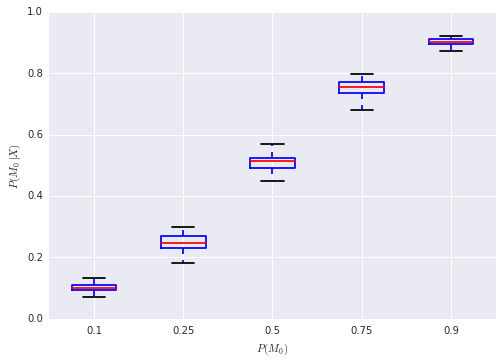

In [43]:
#plot P(M0|X) density
plt.show()
import seaborn as sns
plt.boxplot(res_all)
plt.xticks(range(1,len(null_priors)+1,1), null_priors)
plt.xlabel(r"$P(M_0)$")
plt.ylabel(r"$P(M_0 \mid X)$")
plt.savefig('null_post.pdf')


(array([ 12.,  49.,  75.,  98.,  77.,  66.,  40.,  21.,  18.,  12.,  10.,
          6.,   4.,   5.,   1.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([ 0.79937065,  0.83815708,  0.8769435 ,  0.91572992,  0.95451635,
         0.99330277,  1.03208919,  1.07087561,  1.10966204,  1.14844846,
         1.18723488,  1.22602131,  1.26480773,  1.30359415,  1.34238057,
         1.381167  ,  1.41995342,  1.45873984,  1.49752627,  1.53631269,
         1.57509911,  1.61388553,  1.65267196,  1.69145838,  1.7302448 ,
         1.76903123,  1.80781765,  1.84660407,  1.88539049,  1.92417692,
         1.96296334]),
 <a list of 30 Patch objects>)

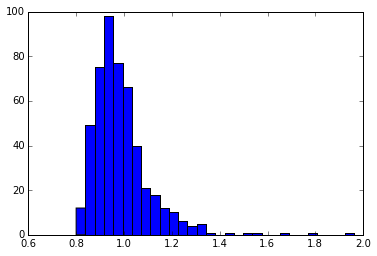

In [79]:
#sum BF = 1?
iter = 0
iters = 500
m = 100
kmax = 3
res = []
res2 =[]

prior_levels = [1./(kmax+1)]*(kmax+1)
sumkpk= 0.
tau = 1.
for k in xrange(1, kmax+1):
    sumkpk += k*prior_levels[k]
    
while iter< iters:
    total = 0.
    dat = np.random.normal(0,1,m)
    for k in xrange(kmax+1):
        total+= prior_levels[k]/ sp.misc.comb(m,k)*sum_Bayes_full(dat, k, 1.)
    res.append(total)
    #res2.append(denominator(dat, 1, tau, kmax, prior_levels))
    #res2.append(1.+ sumkpk/m/sqrt(1.+tau**2)*(exp(0.5*tau**2/(1.+tau**2)*dat[0]**2)-1))
    iter += 1
plt.show()
plt.hist(res, bins = 30)
plt.hist(res2, bins = 30)

In [ ]:
while(iter < iters):
    sample = np.random.normal(0,1,m)
    
    res.append(temp / (1. + temp))
    iter += 1

[5, 6, 7, 8, 9, 11, 12, 13, 14, 15]
5
6
7
8
9
11
12
13
14
15


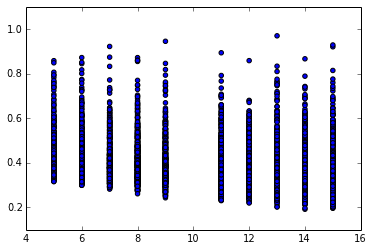

In [8]:
iters = 500
m0 =5
m1 =15 
m_arr = map(lambda x: int(round(x)),  np.linspace(m0, m1, 10))
print m_arr
#save = [ x[:] for x in [[0]*iters]*len(m_arr)]
save = []
count = 0

for m in m_arr:
    prior_levels = [1./(m+1)]*(m+1)
    for iter in xrange(iters):
        sample = np.random.normal(0,1,m)
        save.append((m, inclusion_post(sample, 1, 1., m, prior_levels)))
    print m


plt.scatter( [ save[i][0] for i in xrange(0,len(save))], [ save[i][1] for i in xrange(0,len(save))]) 

In [25]:
# plot theta versus P(mu | x)
m = 100
kmax = 3
iters = 100
theta0 = 0
theta1 = 8
theta_arr = np.linspace(theta0, theta1, 25)
print theta_arr
#save = [ x[:] for x in [[0]*iters]*len(m_arr)]
res = []


prior_levels = [1./(kmax+1)]*(kmax+1)
for theta in theta_arr:
    for iter in xrange(iters):
        sample = np.random.normal(0,1,m)
        sample[0] = theta
        res.append((theta, inclusion_post(sample, 1, 1., kmax, prior_levels)))
    #print theta
    
#plt.scatter( [ res[i][0] for i in xrange(0,len(res))], [ res[i][1] for i in xrange(0,len(res))]) 

[ 0.          0.33333333  0.66666667  1.          1.33333333  1.66666667
  2.          2.33333333  2.66666667  3.          3.33333333  3.66666667
  4.          4.33333333  4.66666667  5.          5.33333333  5.66666667
  6.          6.33333333  6.66666667  7.          7.33333333  7.66666667
  8.        ]


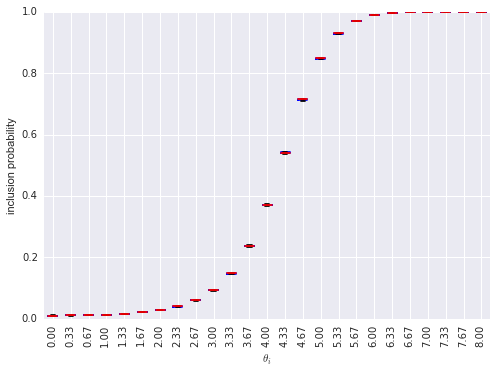

In [26]:
# boxplots of inclusion prob v.s. theta 
all_res =[]
for theta in theta_arr:
    dat1 = []
    for i in xrange(0,len(res)):
        if res[i][0]== theta:
            dat1.append(res[i][1])
    all_res.append(dat1)
plt.show()
plt.boxplot(all_res)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ylabel_simplified = map(lambda x: '%.2f' % x, theta_arr) #only display two decimal places
plt.xticks(range(1,len(theta_arr)+1,1), ylabel_simplified)
plt.xlabel(r'$\theta_i$')
plt.ylabel(r'inclusion probability')
plt.savefig('power_versus_m.pdf')

In [66]:
#save
import csv

f = open('theta_vs_inclusion_prob.csv','wb') # write mode binary
fw = csv.writer(f) # create csv writer
fw.writerows(save) 
f.close() # close file 


In [18]:
# historgram of ratios of inclusion probability (true/ est)
m = 100
iters = 500
iter = 0
res = []
kmax = 3
prior_levels = [1./(kmax+1)]*(kmax+1)
sumkpk= 0.
tau = 1.
for k in xrange(1, kmax+1):
    sumkpk += k*prior_levels[k]
    

while(iter < iters):
    sample = np.random.normal(0,1,m)
    temp1 =     inclusion_post(sample, 3,  1., kmax, prior_levels)
    temp2 =     inclusion_post_est(sample, 3,  1., kmax, prior_levels)
    #print iter, temp1, temp2
    res.append(temp1/temp2)
    iter += 1

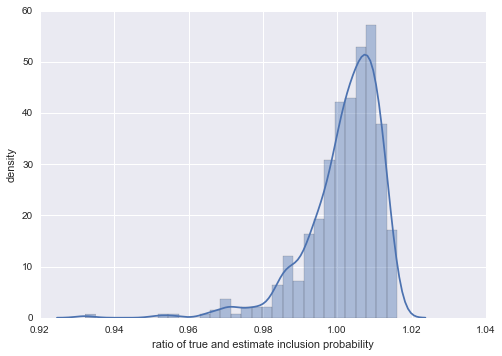

In [23]:
# density plot 
import seaborn as sns
from scipy.stats import gaussian_kde

#f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
#xx = np.linspace(0.9, 1.3, 100)
#scipy_kde = sp.stats.gaussian_kde(np.asarray(res))(xx)
#ax2.plot(xx, scipy_kde, c=c2)
#density = gaussian_kde(np.array(res))
#sns.kdeplot(np.array(res))#[res[i][1] for i in xrange(0,len(res))])#, shade=True);
#plt.hold(True) 
#sns.set_palette("hls")
#density = gaussian_kde(res)
#xs = np.linspace(0.94,1.03,200)
#density.covariance_factor = lambda : .25
#density._compute_covariance()
#plt.plot(xs,density(xs))
plt.show()
sns.distplot(np.array(res))#[res[i][1] for i in xrange(0,len(res))])#, shade=True);
plt.xlabel('ratio of true and estimate inclusion probability')
plt.ylabel('density')

plt.savefig('inclusion_prob_ratio_true_est.pdf')

#plt.plot(density)
#plt.hist(res, bins = 30)

#savefig('inclusion_prob_ratio_true_est.pdf')

# fixed threshold = 0.05, compute FPP (alpha) 

In [ ]:
# fixed threshold = 0.05, compute FPP (alpha)
from math import exp, log, gamma,sqrt, pi
iters = 100  ### FPP = #{FP} / iters
counts = 100 ### the number of simulations for fixed m
m0 =50
m1 =100
kmax = 3
tau = 1.0
m_arr = sorted(list(set(map(lambda x: int(round(x)), np.linspace(m0, m1, 4)))))
#m_arr = [300]
print m_arr
res = []
numerator = 0
kmax = 2
for m in m_arr:
    prior_levels = [1./(kmax+1)]*(kmax+1)
    sumkpk = 0.
    for k in xrange(1, kmax+1):
        sumkpk += k*prior_levels[k]

    # threshold
    threshold = 0.05
    # FPP
    count = 0
    while count < counts:
        temp_m = 0.
        temp_true_sum = 0.
        temp_est_sum = 0.
        FP = 0.
        for iter in xrange(iters):
        # compute FPP 
            sample = np.random.normal(0,1,m)
            # compute FP (yes or no) in each iteration    
            for channel in xrange(1, m+1):
                #temp =      inclusion_post(sample, channel, tau, kmax, prior_levels) 
                temp =     inclusion_post_est(sample, channel, tau, kmax, prior_levels) 
                #print temp, temp2
                if temp > threshold:
                    FP += 1.
                    break
                #temp_m += FPP(sample, tau, kmax, prior_level, threshold+0.01) # +1 if a false positive occurs
                #print temp_true_sum / iters
        if iter%20==0:
            print 'm= %d, FPP = %d'% (m, FP / iters)
        res.append((m, FP / iters))
        count += 1
 
# plt.scatter( [ res[i][0] for i in xrange(0,len(res))], [ res[i][1] for i in xrange(0,len(res))]) 

0.05
500
0.0729567425216
567
0.0635579300425
633
0.056323258684
700
0.050433574111


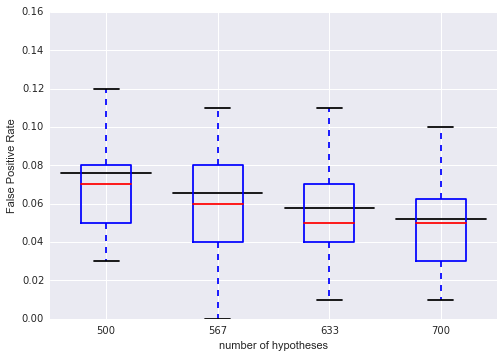

In [40]:
all_res =[]
import seaborn as sns
#print m_arr.remove(150)
#print m_arr
for m in m_arr:
    dat1 = []
    for i in xrange(0,len(res)):
        if res[i][0]== m:
            dat1.append(res[i][1])
    all_res.append(dat1)
print threshold
plt.show()
num_plot = 0
#theoretical FPP:
for m in m_arr:
    print m
    theory_val = 1. - (1. - 1./m * (sumkpk*(1-threshold)/threshold)**((1.+tau**2)/tau**2) /   \
                 m**(1/tau**2)*(log(threshold/(1-threshold)*sqrt(1+tau**2)*(m/sumkpk-1)))**(-0.5)* \
                       tau/sqrt(pi)*(1+tau**2)**(-1.-0.5/tau**2))**m
    theory_val2 = (sumkpk*(1-threshold)/threshold)**((1.+tau**2)/tau**2) /   \
                 m**(1/tau**2)*(log(threshold/(1-threshold)*sqrt(1+tau**2)*(m/sumkpk-1)))**(-0.5)* \
                       tau/sqrt(pi)*(1+tau**2)**(-1.-0.5/tau**2)
    print theory_val
 #   plt.plot([num_plot+0.6,num_plot+1.4],[theory_val,theory_val], 'black')
    plt.plot([num_plot+0.6,num_plot+1.4],[theory_val2,theory_val2], 'black')
    num_plot +=1
    plt.hold(True) 

test = plt.boxplot(all_res)#,  order=np.arange(1, 7), palette="Blues_d")
locs, labels = plt.xticks()
#plt.setp(labels, rotation=90)
plt.xticks(range(1,len(m_arr)+1,1), m_arr)
plt.xlabel('number of hypotheses')
plt.ylabel('False Positive Rate')
plt.savefig('FPP_true_pred.pdf')

In [38]:
#theoretical FPP:
print m 
threshold =0.05
print (sumkpk*(1-threshold)/threshold)**((1.+tau**2)/tau**2) / m**(1/tau**2)*(log(threshold/(1-threshold)*sqrt(1+tau**2)*(m/sumkpk-1)))**(-0.5)*tau/sqrt(pi)*(1+tau**2)**(-1.-0.5/tau**2)


300
0.136271378787


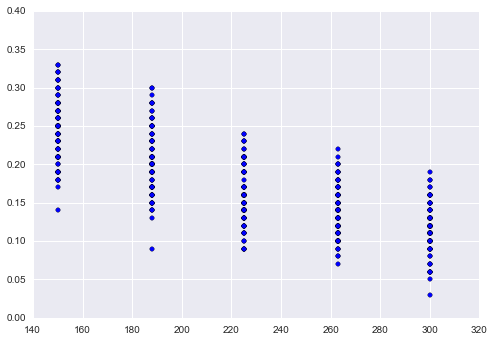

In [39]:
plt.scatter( [ res[i][0] for i in xrange(0,len(res))], [ res[i][1] for i in xrange(0,len(res))]) 

In [32]:
kmax =2 
prior_levels = [1./(kmax+1)]*(kmax+1)
sumkpk = 0.
for k in xrange(1, kmax+1):
    sumkpk += k*prior_levels[k]

In [53]:
threshold =0.05
for m in m_arr:
    print (sumkpk*(1-threshold)/threshold)**((1.+tau**2)/tau**2) / m**(1/tau**2)*(log(threshold/(1-threshold)*sqrt(1+tau**2)*(m/sumkpk-1)))**(-0.5)*tau/sqrt(pi)*(1+tau**2)**(-1.-0.5/tau**2)
#print log(2.71)

0.0346900239093
0.0251964939967
0.019674963841
0.0160976367833


# fixed threshold = 0.05, under alternative model (theta2 != 0), compute FPP (alpha)

In [ ]:
# fixed threshold = 0.05, under alternative model (theta2 != 0), compute FPP (alpha)
from math import exp, log, gamma,sqrt, pi
iters = 100  ### FPP = #{FP} / iters
counts = 300 ### the number of simulations for fixed m
m = 300
theta0 =0.5
theta1 =4.5
kmax = 3
tau = 1.0
theta_arr = np.linspace(theta0, theta1, 6)
#m_arr = [300]
#print m_arr
res = []
numerator = 0
kmax = 2
theta2 = 1.
for theta in theta_arr:
    prior_levels = [1./(kmax+1)]*(kmax+1)
    sumkpk = 0.
    for k in xrange(1, kmax+1):
        sumkpk += k*prior_levels[k]

    # threshold
    threshold = 0.05
    # FPP
    count = 0
    while count < counts:
        temp_m = 0.
        temp_true_sum = 0.
        temp_est_sum = 0.
        FP = 0.
        for iter in xrange(iters):
        # compute FPP 
            sample = np.random.normal(0,1,m)
            sample[1] = theta
            # compute FP (yes or no) in each iteration    
            for channel in xrange(1, m+1):
                #temp =      inclusion_post(sample, channel, tau, kmax, prior_levels) 
                temp =     inclusion_post_est(sample, channel, tau, kmax, prior_levels) 
                #print temp, temp2
                if temp > threshold:
                    FP += 1.
                    break
                #temp_m += FPP(sample, tau, kmax, prior_level, threshold+0.01) # +1 if a false positive occurs
                #print temp_true_sum / iters
        if iter%20==0:
            print 'm = %d, theta= %d, FPP = %d'% (m, theta, FP / iters)
        res.append((m, theta, FP / iters))
        count += 1
 
# plt.scatter( [ res[i][0] for i in xrange(0,len(res))], [ res[i][1] for i in xrange(0,len(res))]) 

[1, 3, 11, 38, 129, 433, 1459, 4915]


# testing threshold which guarantee fixed FPP (alpha) 

In [47]:
# testing threshold which guarantee fixed FPP (alpha) ### RUN in Hardac ###
from math import exp, log, gamma,sqrt, pi
alpha = 0.05  ### empirical FPP should be alpha
iters = 500  ### FPP = #{FP} / iters
counts = 500 ### the number of simulations for fixed m
#m0 =100
#m1 =5000
kmax = 2
tau = 3.0
#m_arr = sorted(list(set(map(lambda x: int(round(x)), np.linspace(m0, m1, 5)))))
m_arr = sorted(list(set(map(lambda x: int(round(exp(x))), np.linspace(2.3, 3.8, 8)))))
#m_arr = [10000]
print m_arr
res = []
res_arr = []
numerator = 0
num_plot = 0

for m in m_arr:
    prior_levels = [1./(kmax+1)]*(kmax+1)
    sumkpk = 0.
    for k in xrange(1, kmax+1):
        sumkpk += k*prior_levels[k]

    # threshold
    numerator = sumkpk * (m**(-1./(1.+tau**2))) *(pi*(alpha**2)*log(m))**(-tau**2/2./ (1.+tau**2)) / sqrt(1.+tau**2)#/ (1- sumkpk/m)
    threshold = numerator / (1. + numerator)
    print 'threshold =', str( threshold)
    # FPP
    count = 0
    res_m = []
    while count < counts:
        temp_m = 0.
        temp_true_sum = 0.
        temp_est_sum = 0.
        FP = 0.
        for iter in xrange(iters):
        # compute FPP 
            sample = np.random.normal(0,1,m)
            # compute FP (yes or no) in each iteration    
            for channel in xrange(1, m+1):
                #temp =      inclusion_post(sample, channel, tau, kmax, prior_levels) 
                temp =     inclusion_post_est(sample, channel, tau, kmax, prior_levels) 
                #print temp, temp2
                if temp > threshold:
                #if abs(sample[channel-1])>sqrt(2*log(m / sqrt(pi*alpha**2*log(m)))):
                    FP += 1.
                    break
                #temp_m += FPP(sample, tau, kmax, prior_level, threshold+0.01) # +1 if a false positive occurs
                #print temp_true_sum / iters
        if iter%200==0:
            print 'm= %d, FPP = %d'% (m, FP / iters)
        res.append((m, FP / iters))
        #print res
        count += 1

 
# plt.scatter( [ res[i][0] for i in xrange(0,len(res))], [ res[i][1] for i in xrange(0,len(res))]) 

[10, 12, 15, 19, 24, 29, 36, 45]
threshold = 0.604479452958
threshold = 0.591855585801
threshold = 0.577039036642
threshold = 0.562011810247
threshold = 0.547756876932
threshold = 0.536599165251
threshold = 0.524238683174
threshold = 0.511881021561


In [49]:
#save to csv
import csv
## WARNING: check file name before save ##

with open('fixed_power_alpha_iter_counts_005_500_500_10_50.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['m','FPP'])
    for row in res:
        csv_out.writerow(row)

[10, 12, 15, 19, 24, 29, 36, 45]


{'boxes': [<matplotlib.lines.Line2D at 0x10a59cc90>,
 'caps': [<matplotlib.lines.Line2D at 0x10a60afd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x10ae8c690>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10ae8c910>,
 'whiskers': [<matplotlib.lines.Line2D at 0x10acadd50>,
  <matplotlib.lines.Line2D at 0x10be30910>]}

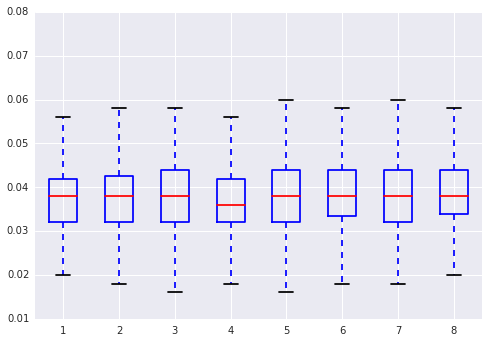

In [50]:
all_res =[]
#print m_arr.remove(150)
print m_arr
#m_arr.remove(5000)

for m in m_arr:
    dat1 = []
    for i in xrange(0,len(res)):
        if res[i][0]== m:
            dat1.append(res[i][1])
    all_res.append(dat1)
plt.boxplot(all_res)
#print all_res

In [224]:
m_arr = sorted(list(set(map(lambda x: int(round(exp(x))), np.linspace(2, 8.5, 8)))))

0.34458833741

49
84
142
241
409
694
1178
1998


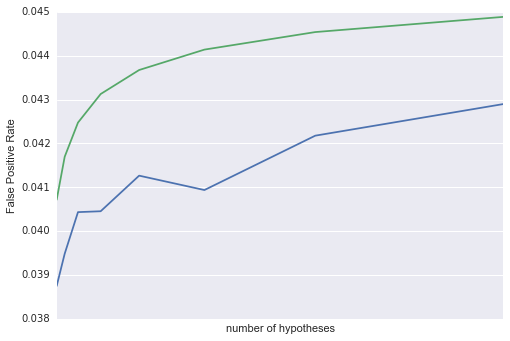

In [29]:
# boxplots 
import seaborn as sns
all_res =[]
#print m_arr.remove(150)
#print m_arr
for m in m_arr:
    dat1 = []
    for i in xrange(0,len(res)):
        if res[i][0]== m:
            dat1.append(res[i][1])
    all_res.append(dat1)
print threshold
plt.show()
num_plot = 0
#plt.boxplot(all_res)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.xticks(range(1,len(m_arr)+1,1), m_arr)
plt.xlabel('number of hypotheses')
plt.ylabel('False Positive Rate')
means,theory = [], []
print
#theoretical FPP:
for m in m_arr:
    print m
    #theory_val = (sumkpk*(1-threshold)/threshold)**((1.+tau**2)/tau**2) / m**(1/tau**2)*(log(threshold/(1-threshold)*sqrt(1+tau**2)*(m/sumkpk-1)))**(-0.5)*tau/sqrt(pi)*(1+tau**2)**(-1.-0.5/tau**2)
    #theory_val = 1. - (1. - 1./m /sqrt(pi)/sqrt(log(m)))**m
    #theory_val = alpha 
    theory_val2 = 1. - (1. - alpha/m/sqrt(1.-log(pi*alpha**2*log(m))/2./log(m)))**m
    #theory_val2 = 1. - (1. - alpha/m)**m
    #print theory_val
    #print num_plot
    means.append(np.mean(all_res[num_plot]))
    theory.append(theory_val2)
    #plt.plot([num_plot+0.6,num_plot+1.4],[theory_val,theory_val],'black')
    #plt.plot([num_plot+0.6,num_plot+1.4],[theory_val2,theory_val2])
    num_plot +=1
    #plt.hold(True) 
plt.plot(m_arr, means)
plt.plot(m_arr, theory)
    
    
#plt.savefig('fixed_power.pdf', bbox_inches='tight')


In [52]:
# merge simulation results
import csv
res_dict = {}
#filenames = ['fixed_power2.csv','fixed_power3.csv','fixed_power4.csv','fixed_power5.csv']
filenames = ['fixed_power_alpha_iter_counts_005_500_500_0_3000.csv', 'fixed_power_alpha_iter_counts_005_500_500_10_50.csv']

for filename in filenames:
    with open(filename, 'rb') as f:
        reader = csv.DictReader(f)
        for row in reader:
            temp_m, temp_FPP = int(row['m']), float(row['FPP'])
            #print temp_m, temp_FPP
            if temp_m in res_dict.keys():
                res_dict[temp_m].append(temp_FPP)
                #res_dict[temp_m] = res_dict[temp_m].append(temp_FPP)
            else:
                res_dict.update({temp_m: [temp_FPP]})
            #print res_dict
#print res_dict
print res_dict.keys()
        

[36, 241, 10, 12, 45, 1998, 15, 49, 19, 84, 142, 694, 24, 409, 1178, 29]


0.511881021561
10
12
15
19
24
29
36
45
49
84
142
241
409
694
1178
1998


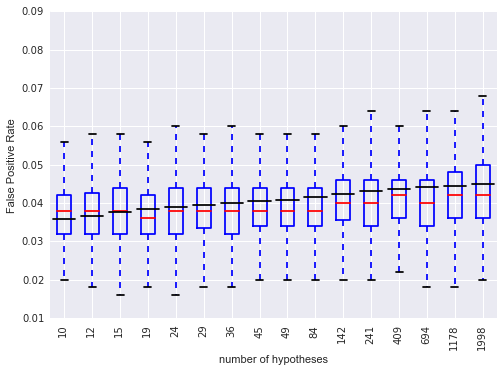

In [53]:
# boxplots for all simulations
import seaborn as sns
all_res =[]
m_arr = sorted(res_dict.keys())

for m in m_arr:
    dat1 = []
    all_res.append(res_dict[m])

print threshold
plt.show()
num_plot = 0
plt.boxplot(all_res)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.xticks(range(1,len(m_arr)+1,1), m_arr)
plt.xlabel('number of hypotheses')
plt.ylabel('False Positive Rate')
means = []

#theoretical FPP:
for m in m_arr:
    print m
    #theory_val = (sumkpk*(1-threshold)/threshold)**((1.+tau**2)/tau**2) / m**(1/tau**2)*(log(threshold/(1-threshold)*sqrt(1+tau**2)*(m/sumkpk-1)))**(-0.5)*tau/sqrt(pi)*(1+tau**2)**(-1.-0.5/tau**2)
    #theory_val = 1. - (1. - 1./m /sqrt(pi)/sqrt(log(m)))**m
    #theory_val = alpha 
    theory_val2 = 1. - (1. - alpha/m/sqrt(1.-log(pi*alpha**2*log(m))/2./log(m)))**m
    #means.append( np.mean(res_dict[m]) ) 
    #print theory_val
    #plt.plot([num_plot+0.6,num_plot+1.4],[theory_val,theory_val],'black')
    #plt.plot([num_plot+0.6,num_plot+1.4],[ np.mean(res_dict[m]), np.mean(res_dict[m])],'green')
    plt.plot([num_plot+0.6,num_plot+1.4],[theory_val2,theory_val2],'black')
    num_plot +=1
    #plt.hold(True) 

plt.savefig('fixed_power.pdf', bbox_inches='tight')


In [207]:
#map(lambda x: log(x), )
(res_dict[m])

0.0

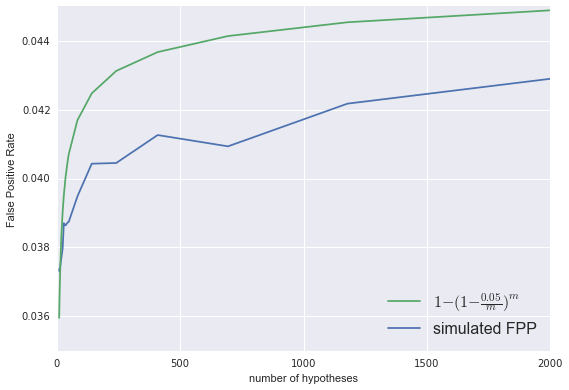

In [58]:
# means for all simulations
import seaborn as sns
from matplotlib.legend_handler import HandlerLine2D
all_res =[]
m_arr = sorted(res_dict.keys())
means = []
theory = []

for m in m_arr:
    dat1 = []
    means.append( np.mean(res_dict[m]) ) 
    theory_val2 = 1. - (1. - alpha/m/sqrt(1.-log(pi*alpha**2*log(m))/2./log(m)))**m
    theory.append(theory_val2)

locs, labels = plt.xticks()
#plt.setp(labels, rotation=90)
#plt.xticks(range(1,len(m_arr)+1,1), m_arr)
plt.xlabel('number of hypotheses')
plt.ylabel('False Positive Rate')
#line0, = plt.plot(m_arr, [0.05]*len(m_arr), label = r"alpha")
grid = m_arr
grid_new = np.linspace(min(m_arr), max(m_arr), 300)

#line1, = plt.plot(grid_new, spline(grid, means, grid_new ), label = 'simulated FPP' )
line2, = plt.plot(m_arr, means,  label = 'simulated FPP' )
line1, = plt.plot(m_arr, theory, label = r"$1-(1-\frac{0.05}{m})^m$")
plt.legend(handles=[line1, line2], loc =4 ,prop={'size':16})
plt.tight_layout()
plt.savefig('fixed_power.png')

[0.035650000000000015, 0.03265000000000004, 0.029630000000000017, 0.029706666666666715, 0.029826666666666668, 0.029173333333333329, 0.029443333333333294, 0.027676666666666683, 0.027550000000000047, 0.027750000000000025, 0.027700000000000002, 0.027353333333333313, 0.027266666666666634, 0.027496666666666669, 0.02851666666666669, 0.027723333333333378, 0.028000000000000025, 0.026756666666666651, 0.026352657004830915]


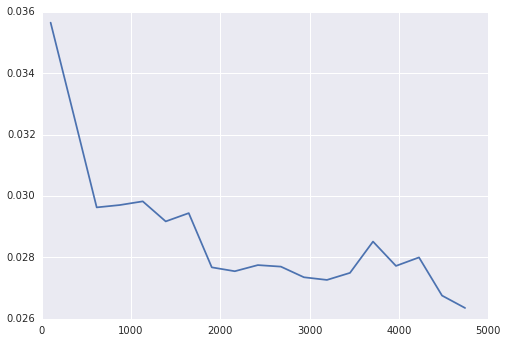

In [102]:
# plot empirical & theoretical mean in log scale
import seaborn as sns
all_res =[]
theory_res = []
#print m_arr.remove(150)
#print m_arr
for m in m_arr:
    all_res.append(alpha - np.mean([res[i][1] for i in xrange(len(res)) if res[i][0] == m ]))
   # theory_res.append(1. - (1. - alpha/m)**m)
plt.plot(m_arr, all_res)
print all_res
#plt.plot(m_arr, theory_res)

In [131]:
sqrt(1- log(log(300))/2./log(300))
m = 1e4

#compute error


0.0477321268622


In [163]:
m = 1e25
temp= sqrt(1-log(log(m))/log(m)-log(pi*0.01**2)/log(m))
print temp
print 0.01 / temp

1.03426678241
0.0096686852658


In [45]:
m0 =7
m1 =14
alpha = 0.9
tau = 1.0
counts = 50
iters = 500
res = []
m_arr = (list(set(map(lambda x: int(round(x)), np.linspace(m0, m1, 7)))))
print m_arr

kmax = 3

for m in m_arr:
    #kmax = int(round(m/3.))
    prior_levels = [1./(kmax+1)]*(kmax+1)
    sumkpk = 0.
    # threshold
    for k in xrange(0, kmax+1):
        sumkpk += k*prior_levels[k]
    numerator = sumkpk * (m**(-1./(1.+tau**2))) *(pi*(alpha**2)*log(m))**(-tau**2/2./ (1.+tau**2)) / sqrt(1.+tau**2)
    threshold = numerator / (1. + numerator)    
    print m, kmax,  threshold
    count = 0
    while count < counts:
        temp_m = 0
        for iter in xrange(iters):
            sample = np.random.normal(0,1,m)
            if inclusion_post(sample, channel, tau, kmax, prior_levels) > threshold:
                temp_m += 1.
        res.append((m, temp_m/ iters))
        count += 1
    print m
 
 
plt.scatter( [ res[i][0] for i in xrange(0,len(res))], [ res[i][1] for i in xrange(0,len(res))]) 
    threshold = numerator / (1. + numerator)    
    print m, kmax,  threshold
    count = 0
    while count < counts:
        temp_m = 0
        for iter in xrange(iters):
            sample = np.random.normal(0,1,m)
            if inclusion_post(sample, tau, kmax, prior_levels) > threshold:
                temp_m += 1.
        res.append((m, temp_m/ iters))
        count += 1
    print m
 
 
plt.scatter( [ res[i][0] for i in xrange(0,len(res))], [ res[i][1] for i in xrange(0,len(res))]) 

IndentationError: unexpected indent (<ipython-input-45-df3c916a62ef>, line 36)

# posterior probability of p #

In [21]:
### posterior probability of p ###

k = 1
dat = np.random.normal(0,1,100)
tau = 1.
kmax = 5

def sum_likelihood_level(dat, tau, k):
    m = len(dat)
    comb_null = itertools.combinations(range(0,m), k)
    #print comb_null
    res = []
    tausq = tau**2
    
    for gamma in comb_null: #gamma = tuple
        #print gamma
        logLH = 0.          #loglikelihood 
        # probably can count # of nonzero idx (after it reaches kmax, no nonull model)
        for idx in xrange(m):
            if idx not in gamma:
                logLH += -0.5*dat[idx]**2
            else:
                logLH += -0.5*log(1.+tausq) -0.5/(1.+tausq)*dat[idx]**2
        res.append(exp(logLH))
    #print res
    return sum(res)

def post_p(dat, tau, kmax, p_arr):
    m = len(dat)
    numerator = [0]*len(p_arr)
    denominator = 0.
    for k in xrange(kmax+1):
        sum_LH = sum_likelihood_level(dat, tau, k)
        for i in xrange(len(p_arr)):
            numerator[i] += sum_LH * (p_arr[i]**k)*((1-p_arr[i])**(m-k))
        denominator += sum_LH / (kmax + 1) / sp.misc.comb(m,k)
    return map(lambda x: x / denominator, numerator)

from operator import add
def noisy_dat(m, proportion, tau):
    dat = np.random.normal(0, 1, m)
    # generate noise (std = tau)
    cutoff = int(round(proportion*m))
    dat2 = np.random.normal(0, tau, cutoff)
    dat2 = list(dat2) + [0.]*(m-cutoff)
    #print cutoff, dat2
    return map(add, dat, dat2)



#A =  map(lambda x: exp( -0.5* x**2), dat )
#B =  map(lambda x: (1.0 + tau **2)**(-0.5)* exp( -0.5* x**2 /(1.+tau**2) ), dat )


#likelihood_null = [reduce(mul, comb) for comb in itertools.combinations(A, k)]
#likelihood_nonnull = [reduce(mul, comb) for comb in itertools.combinations(B, k)]
#likelihood = 



In [37]:
m = 20
tau = round(sqrt(2*log(m)))
#kmax = int(round(m**(1./(1.+tau**2))))
#tau = 1.
kmax = 20
print tau, kmax
grid = list(np.linspace(0,0.4,7))+[0.6, 0.85, 1]
print grid
#est. complexity
complexity = 0.
for k in xrange(kmax+1):
    complexity +=  sp.misc.comb(m,k)
complexity *= m
print 'the log complexity is', log(complexity)


2.0 20
[0.0, 0.066666666666666666, 0.13333333333333333, 0.20000000000000001, 0.26666666666666666, 0.33333333333333331, 0.40000000000000002, 0.6, 0.85, 1]
the log complexity is 16.8586758848


In [38]:
res1 = post_p(noisy_dat(m,0,  tau), tau, kmax, grid)
print res1
res2= post_p(noisy_dat(m,0.25,tau), tau, kmax, grid)
print res2
res3= post_p(noisy_dat(m,0.5,tau), tau, kmax, grid)
print res3
res4= post_p(noisy_dat(m,0.75,tau), tau, kmax, grid)
print res4
res5=  post_p(noisy_dat(m,1 ,tau), tau, kmax, grid)
print res5

[6.4856759627936453, 4.3372475798135133, 2.8523955915302315, 1.8431098837999347, 1.1689410610785127, 0.72681785604416826, 0.4424567347295153, 0.086491576880874985, 0.0077188013975260728, 0.0013846289101663509]
[1.9158089534887919, 1.9773123474497032, 1.9323557768777051, 1.8090479179787675, 1.634220104256058, 1.4312550206556975, 1.2190783710398696, 0.64842155429817616, 0.21785411663340495, 0.095195893849275473]
[0.0026601317620555285, 0.29442480094709528, 0.75495316572007087, 1.244217001220782, 1.6384674027868071, 1.8646737914672706, 1.9051278390668296, 1.264403660672808, 0.34085966727680539, 0.10196985169300304]
[5.71262015901854e-06, 0.0032480250677980778, 0.022243460160675882, 0.078128861311324335, 0.1938653374513124, 0.38457246845196319, 0.64930419050502264, 1.6054061102867985, 1.8534816214290171, 1.2999417410615182]
[4.5312987198569885e-13, 1.2048503603789837e-05, 0.00027145624766365911, 0.0021018252684671412, 0.0096970723557525361, 0.032472232218385529, 0.086949623391059855, 0.691

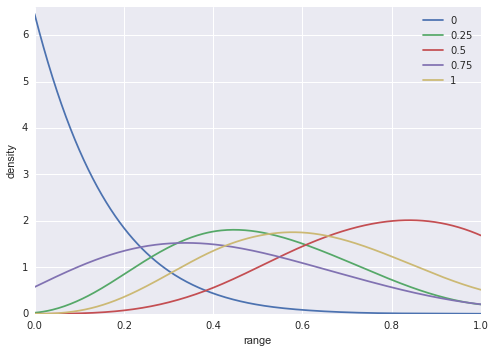

In [36]:
import seaborn as sns

plt.figure()
# plot histgram of sample
#plt.hist(res1, bins=20, normed=1)
# plot data generating density
#plt.plot(grid, stats.norm.pdf(grid), color="r", label='DGP normal')
# plot estimated density
#plt.plot(grid, kdepdf, label='kde', color="g")
locs, labels = plt.xticks()
axes = plt.gca()
maxy = max(max(res1),max(res2),max(res3),max(res4),max(res5))
axes.set_ylim([0,maxy+0.15])
#plt.setp(labels, rotation=90)

plt.ylabel('density')
plt.xlabel('range')
plt.legend()
#plt.show()

from scipy.interpolate import spline 


#plt.xticks(range(len(grid)), map(lambda x: round(x,2), grid))
grid_new = np.linspace(min(grid), max(grid), 300)
noisy0, = plt.plot(grid_new, spline(grid, res1, grid_new ), label = '0')
noisy1, = plt.plot(grid_new, spline(grid, res2, grid_new ), label = '0.25')
noisy2, = plt.plot(grid_new, spline(grid, res3, grid_new ), label = '0.5')
noisy3, = plt.plot(grid_new, spline(grid, res4, grid_new ), label = '0.75')
noisy4, = plt.plot(grid_new, spline(grid, res5, grid_new ), label = '1')

plt.legend(handles= [noisy0, noisy1, noisy2, noisy3, noisy4])
#plt.legend((m, kmax), ('m','k'))
#titlestr = "$m=%d, k_{max} = %d$" %(m, kmax)
#plt.title(r"Posterior of p versus $\frac{\# \,noise}{\# \,observations}$"+'\n m=%s; '%m +r"$\tau$="+"%s"%tau+ " ;" + r"$k_{max}$="+"%s"%kmax)
#plt.tight_layout()
filename = 'post_p_%d_%d.pdf' %(m,k) 
plt.savefig(filename)


In [59]:
map(add, [1,2,3], [3,4,5])

print [3,4,5]+[0]*(m-cutoff)
print m-cutoff
print list(dat2) + [0.]*(m-cutoff)

[3, 4, 5, 0, 0, 0, 0, 0]
5
[0.066034668087667017, -1.5201580738631832, 2.1386887167346678, 0.49714533771659009, 0.66934996657435919, 0.0, 0.0, 0.0, 0.0, 0.0]


In [71]:
### Debug session ###
### check the true inclusion prob is correct ###

def denominator(sample, channel, tau, kmax, prior_level):
    ''' get inclusion probability  '''
    m = len(sample)
    sumBF_arr =[]
    
    # save Bayes factors without the channel 
    subsample = np.append(sample[:(channel-1)],sample[channel:])
    for k in xrange(0, kmax+1): 
        temp = sum_Bayes_full(subsample, k, tau)
        #print ' k =  ' + str(k) +  '; sum BF excluding x[channel] ' + str(temp)
        sumBF_arr.append(temp)
    print temp
    
    full_sum_BF= [sumBF_arr[0]]
    BFchannel = (1.0 + tau **2)**(-0.5) * exp( tau**2 / (1.0 + tau**2) /2.0 * sample[channel-1]**2)
    for k in xrange(1, kmax+1):
        full_sum_BF.append(sumBF_arr[k]+BFchannel*sumBF_arr[k-1])
    #full_sum_BF.append(BFchannel*sumBF_arr[kmax-1])
    print full_sum_BF
    
    
    numerator = 0.
    for k in xrange(1, kmax+1):
        numerator += prior_level[k]/sp.misc.comb(m,k)*sumBF_arr[k-1]*BFchannel
    denominator = numerator
    for k in xrange(0, kmax):
        denominator +=  prior_level[k]/sp.misc.comb(m,k)*sumBF_arr[k]
    #print denominator
    return denominator

#sum BF = 1?
iter = 0
iters = 500
m = 5
kmax = 3
res = []
res2 =[]

prior_levels = [1./(kmax+1)]*(kmax+1)
sumkpk= 0.
tau = 1.
for k in xrange(1, kmax+1):
    sumkpk += k*prior_levels[k]
    
total = 0.
dat = np.random.normal(0,1,m)
#print dat
for k in xrange(kmax+1):
        res.append(sum_Bayes_full(dat, k, 1.))
#print dat
#print dat[1::]
print denominator(dat, 1, tau, kmax, prior_levels)
print res
BFchannel = (1.0 + tau **2)**(-0.5) * exp( tau**2 / (1.0 + tau**2) /2.0 * dat[0]**2)


#which one is right?
print sum_Bayes_full(dat, 3, tau)
print sum_Bayes_full(dat[1::], 2, tau)*BFchannel
print (1.0 + tau **2)**(-1.5) * exp( tau**2 / (1.0 + tau**2) /2.0 * (dat[0]**2+dat[1]**2+dat[2]**2))

